## import libraries

In [1]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import os
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode 
from langgraph.types import Command
from langgraph.types import interrupt
from langgraph.checkpoint.memory import InMemorySaver
from typing import Optional

load_dotenv()



True

## create DB

In [2]:
## create DB

In [3]:
import sqlite3
import os
import random
from datetime import date, timedelta
DB_FILE = "sports_data.db"

RONALDO_ID = 1
MESSI_ID = 2
NEYMAR_ID = 3

def create_database_schema(cursor):
  """Creates the necessary tables for the sports database."""
  print("Creating database schema...")
  # Using INTEGER PRIMARY KEY for auto-incrementing ID in SQLite
  cursor.execute('''
              CREATE TABLE IF NOT EXISTS Teams (
              team_id INTEGER PRIMARY KEY,
              team_name VARCHAR(100) NOT NULL UNIQUE,
              sport VARCHAR(50) NOT NULL
              )''')

  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Players (
      player_id INTEGER PRIMARY KEY,
      player_name VARCHAR(100) NOT NULL,
      team_id INTEGER REFERENCES Teams(team_id),
      position VARCHAR(50)
  )''')

  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Matches (
      match_id INTEGER PRIMARY KEY,
      match_date DATE NOT NULL,
      home_team_id INTEGER REFERENCES Teams(team_id),
      away_team_id INTEGER REFERENCES Teams(team_id),
      home_score INTEGER,
      away_score INTEGER,
      venue VARCHAR(100)
  )''')

  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Player_Match_Stats (
      stat_id INTEGER PRIMARY KEY,
      player_id INTEGER REFERENCES Players(player_id),
      match_id INTEGER REFERENCES Matches(match_id),
      minutes_played INTEGER,
      goals INTEGER,
      assists INTEGER,
      shots INTEGER,
      shots_on_target INTEGER,
      passing_accuracy FLOAT,
      UNIQUE (player_id, match_id)
  )''')
  print("Schema created successfully.")

In [4]:
def insert_base_data(cursor):
  """Inserts the players and their teams into the database."""
  print("Inserting base data (players and teams)...")
  teams = [
  (1, 'Al-Nassr', 'Soccer'),
  (2, 'Inter Miami CF', 'Soccer'),
  (3, 'Al-Hilal SFC', 'Soccer'),
  (4, 'Manchester United', 'Soccer'), # For opponent variety
  (5, 'FC Barcelona', 'Soccer'), # For opponent variety
  (6, 'Paris Saint-Germain', 'Soccer'), # For opponent variety
  (7, 'Orlando City SC', 'Soccer'), # For opponent variety
  (8, 'Al-Ittihad', 'Soccer') # For opponent variety
  ]
  # Use IGNORE to prevent errors if data already exists
  cursor.executemany("INSERT OR IGNORE INTO Teams (team_id, team_name, sport) VALUES (?, ?, ?)", teams)

  players = [
      (RONALDO_ID, 'Cristiano Ronaldo', 1, 'Forward'),
      (MESSI_ID, 'Lionel Messi', 2, 'Forward'),
      (NEYMAR_ID, 'Neymar Jr.', 3, 'Forward')
  ]
  cursor.executemany("INSERT OR IGNORE INTO Players (player_id, player_name, team_id, position) VALUES (?, ?, ?, ?)", players)
  print("Base data inserted.")

In [5]:
def insert_mock_match_data(cursor):
  """Generates and inserts mock match and stat data for the players."""
  print("Generating and inserting mock match data...")
  match_id_counter = 1
  stat_id_counter = 1
  player_team_map = {
      RONALDO_ID: 1,
      MESSI_ID: 2,
      NEYMAR_ID: 3
  }

  # Generate data for each player
  for player_id in [RONALDO_ID, MESSI_ID, NEYMAR_ID]:
      player_team_id = player_team_map[player_id]
      # Generate 10 matches over the last 2 months
      for i in range(10):
          # --- 1. Create a Match ---
          match_date = date.today() - timedelta(days=random.randint(i * 6, (i + 1) * 6))

          # Decide if home or away game
          is_home_game = random.choice([True, False])
          opponent_team_id = random.choice([t[0] for t in teams if t[0] != player_team_id])

          if is_home_game:
              home_team_id, away_team_id = player_team_id, opponent_team_id
              home_score, away_score = random.randint(1, 4), random.randint(0, 3)
          else:
              home_team_id, away_team_id = opponent_team_id, player_team_id
              home_score, away_score = random.randint(0, 3), random.randint(1, 4)

          match_data = (match_id_counter, str(match_date), home_team_id, away_team_id, home_score, away_score, "Mock Stadium")
          cursor.execute("INSERT INTO Matches VALUES (?, ?, ?, ?, ?, ?, ?)", match_data)

          # --- 2. Create Player Stats for that Match ---
          minutes_played = random.randint(75, 90)
          goals = random.randint(0, 2)
          assists = random.randint(0, 2)
          shots = goals + random.randint(1, 5)
          shots_on_target = goals + random.randint(0, shots - goals)
          passing_accuracy = round(random.uniform(75.0, 95.0), 1)

          stat_data = (stat_id_counter, player_id, match_id_counter, minutes_played, goals, assists, shots, shots_on_target, passing_accuracy)
          cursor.execute("INSERT INTO Player_Match_Stats VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", stat_data)

          # Increment counters
          match_id_counter += 1
          stat_id_counter += 1

  print(f"Inserted {match_id_counter - 1} matches and {stat_id_counter - 1} stat records.")

In [6]:
def main():
  """Main function to set up and populate the database."""
  # Delete old database file if it exists to start fresh
  if os.path.exists(DB_FILE):
    os.remove(DB_FILE)
    print(f"Removed existing database file: {DB_FILE}")
    # Connect to the SQLite database (this will create the file)
  conn = None
  try:
      conn = sqlite3.connect(DB_FILE)
      cursor = conn.cursor()

      # Run the functions
      create_database_schema(cursor)

      # Fetch the list of teams to be used in mock data generation
      global teams
      teams = [(1, 'Al-Nassr'), (2, 'Inter Miami CF'), (3, 'Al-Hilal SFC'),
              (4, 'Manchester United'), (5, 'FC Barcelona'), (6, 'Paris Saint-Germain'),
              (7, 'Orlando City SC'), (8, 'Al-Ittihad')]

      insert_base_data(cursor)
      insert_mock_match_data(cursor)

      # Commit the changes
      conn.commit()
      print("\nDatabase created and populated successfully!")

  except sqlite3.Error as e:
      print(f"Database error: {e}")
  finally:
      if conn:
          conn.close()
          print("Database connection closed.")

In [7]:
main()

Removed existing database file: sports_data.db
Creating database schema...
Schema created successfully.
Inserting base data (players and teams)...
Base data inserted.
Generating and inserting mock match data...
Inserted 30 matches and 30 stat records.

Database created and populated successfully!
Database connection closed.


## sql agent

In [8]:

from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///sports_data.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Matches', 'Player_Match_Stats', 'Players', 'Teams']


In [9]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage, SystemMessage

class State(TypedDict):
    query: str
    sql_result: str
    messages: Annotated[list[AnyMessage], add_messages]

import getpass
import os
from langchain_google_genai import ChatGoogleGenerativeAI



from langchain.chat_models import init_chat_model

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite-001")

from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

c:\Users\Karthikeyan\miniconda3\envs\agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


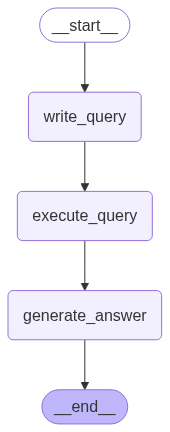

In [ ]:
from typing_extensions import Annotated
import pydantic

class QueryOutput(pydantic.BaseModel):
    query: Annotated[str, "SQL query"]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    print("write query")
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["messages"][-1].content,
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    # print(prompt)
    result = structured_llm.invoke(prompt)
    # print(type(result))
    return {"query": result.query}

from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    print("execute query")
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"sql_result": execute_query_tool.invoke(state["query"])}

def generate_answer(state: State):
    print("generate answer")
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['messages'][-1].content}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['sql_result']}"
    )
    response = llm.invoke(prompt)
    return {"sql_result": response.content}

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
sql_agent = graph_builder.compile()

from IPython.display import Image, display

display(Image(sql_agent.get_graph().draw_mermaid_png()))

In [11]:
sql_agent.invoke({"messages":[HumanMessage(content="messi's match stats")]})

write query
messages=[SystemMessage(content='\nGiven an input question, create a syntactically correct sqlite query to\nrun to help find the answer. Unless the user specifies in his question a\nspecific number of examples they wish to obtain, always limit your query to\nat most 10 results. You can order the results by a relevant column to\nreturn the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the\nfew relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema\ndescription. Be careful to not query for columns that do not exist. Also,\npay attention to which column is in which table.\n\nOnly use the following tables:\n\nCREATE TABLE "Matches" (\n\tmatch_id INTEGER, \n\tmatch_date DATE NOT NULL, \n\thome_team_id INTEGER, \n\taway_team_id INTEGER, \n\thome_score INTEGER, \n\taway_score INTEGER, \n\tvenue VARCHAR(100), \n\tPRIMARY KEY (match_id), \n\tFOREIGN KEY(aw

{'query': "SELECT T1.match_id, T1.minutes_played, T1.goals, T1.assists, T1.shots, T1.shots_on_target, T1.passing_accuracy FROM Player_Match_Stats AS T1 INNER JOIN Players AS T2 ON T1.player_id = T2.player_id WHERE T2.player_name = 'Lionel Messi'",
 'sql_result': "Lionel Messi's match stats include:\n\n*   Match ID: 11, Minutes Played: 81, Goals: 0, Assists: 0, Shots: 2, Shots on Target: 2, Passing Accuracy: 81.4%\n*   Match ID: 12, Minutes Played: 84, Goals: 1, Assists: 2, Shots: 4, Shots on Target: 1, Passing Accuracy: 75.9%\n*   Match ID: 13, Minutes Played: 89, Goals: 0, Assists: 2, Shots: 4, Shots on Target: 2, Passing Accuracy: 79.2%\n*   Match ID: 14, Minutes Played: 75, Goals: 1, Assists: 0, Shots: 4, Shots on Target: 1, Passing Accuracy: 93.8%\n*   Match ID: 15, Minutes Played: 83, Goals: 2, Assists: 2, Shots: 5, Shots on Target: 3, Passing Accuracy: 79.3%\n*   Match ID: 16, Minutes Played: 88, Goals: 1, Assists: 0, Shots: 6, Shots on Target: 2, Passing Accuracy: 85.2%\n*   Mat

## web search agent

In [12]:
from langchain_core.tools import tool
import requests
import json

# NOTE: The ESPN API is not officially public. These endpoints are what the ESPN website uses.
# They can change without notice. This is for demonstration purposes.
# A more robust solution might involve a paid API like SportRadar.
ESPN_NEWS_API_URL = "http://site.api.espn.com/apis/site/v2/sports/{sport}/{league}/news"

@tool
def espn_tool(sport: str, league: str, limit: int = 5) -> str:
    """
    Fetches the latest sports news headlines for a given sport and league from the ESPN API.
    For example, to get the latest NFL news, use sport='football' and league='nfl'.
    To get the latest NBA news, use sport='basketball' and league='nba'.
    To get the latest MLB news, use sport='baseball' and league='mlb'.
    To get the latest Soccer news for the Premier League, use sport='soccer' and league='eng.1'.
    """
    try:
        url = ESPN_NEWS_API_URL.format(sport=sport, league=league)
        params = {'limit': limit}
        response = requests.get(url, params=params)
        response.raise_for_status()  # Will raise an HTTPError for bad responses (4xx or 5xx)
        
        data = response.json()
        articles = data.get('articles', [])
        
        if not articles:
            return f"No recent news found for {sport}/{league}."
            
        # Format the news for the LLM
        formatted_news = []
        for article in articles:
            headline = article.get('headline', 'No Headline')
            description = article.get('description', 'No Description')
            link = article.get('links', {}).get('web', {}).get('href', '#')
            formatted_news.append(f"Headline: {headline}\nSummary: {description}\nLink: {link}\n")
            
        return "\n---\n".join(formatted_news)

    except requests.exceptions.RequestException as e:
        return f"Error fetching news from ESPN API: {e}"
    except json.JSONDecodeError:
        return "Error: Failed to parse JSON response from ESPN API."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

In [13]:
espn_tool.invoke({"sport": "soccer", "league": "eng.1", "limit": 5})

'Headline: Transfer rumors, news: Man Utd\'s Bruno wanted by Al Ittihad\nSummary: Manchester United\'s Bruno Fernandes is still attracting interest from the Saudi Pro League. Transfer Talk has the latest news, gossip and rumors.\nLink: https://www.espn.com/soccer/story/_/id/46062328/transfer-rumors-news-man-utds-bruno-wanted-al-ittihad\n\n---\nHeadline: Man United transfers: GK Lammens left out of Antwerp squad\nSummary: Manchester United target goalkeeper Senne Lammens was left out of Royal Antwerp\'s matchday squad for their Belgian Pro League clash on Sunday.\nLink: https://www.espn.com/soccer/story/_/id/46062822/man-united-transfers-gk-senne-lammens-left-antwerp-squad\n\n---\nHeadline: Arteta: Saka & Ødegaard injuries are negatives\nSummary: Arsenal manager Mikel Arteta believes injuries to Bukayo Saka & Martin Ødegaard are "negatives" despite their 5-0 victory over Leeds.\nLink: https://www.espn.com/video/clip?id=46062698\n\n---\nHeadline: Summer transfer window: Grading big signi

In [14]:
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent

# Initialize Tavily Search Tool
tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

search_agent = create_react_agent(llm, [tavily_search_tool, espn_tool],
                                  prompt="""You are a sports analyst agent. You are given a question about sports news.
perform the following steps:
    - firstly search for the question in web using tavily search tool
    - answer question based on the information obtained
Note:
    call espn_tool tool using leauge name and sport name gathered from search.
give detailed answer, ignore error and give answer based on the information gathered like summary of the information""")

In [15]:
search_agent.invoke({"messages":[HumanMessage(content="Tell me about messi's last match and compare with his last 5 performance")]})

{'messages': [HumanMessage(content="Tell me about messi's last match and compare with his last 5 performance", additional_kwargs={}, response_metadata={}, id='2493b6d6-5dfc-473c-83cf-526ccdae0fa2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "Messi\'s last match"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--00d64c6e-e5d0-4855-8a31-7811f645eb90-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': "Messi's last match"}, 'id': 'c88d5077-784f-4ecd-942f-4e8ed8049e2c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1307, 'output_tokens': 10, 'total_tokens': 1317, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='{"query": "Messi\'s last match", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.threads.com/@soccergenic/post/DNgkky6PxFA/lionel-messi-will-play

## Sports Analyst Agent

In [28]:
class SportState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    sql_result: Optional[str]
    search_result: Optional[str]
    



In [37]:
def search_llm(state: SportState):
    print("---calling search agent---")
    response = search_agent.invoke({"messages":[HumanMessage(content=state["messages"][-1].content)]})
    return {"search_result": response["messages"][-1].content}



In [38]:
class answer_with_query(pydantic.BaseModel):
    answer: Annotated[str, "Answer or summary or stats for the given question based on the extracted information"]
    query: Annotated[list[str], "Question to ask to the user which can be answered from the extracted information"]

In [50]:
class IsContinue(pydantic.BaseModel):
    is_continue: Annotated[bool, "Whether to continue the conversation or not"]

In [ ]:


def analyst_node(state: SportState):
    print("---Analyst Node---")
    # print(state)
    input = [
        SystemMessage(content=f"""You are a sports analyst. Based on the information extracted form web search and internal datatabase,
answer the question by performing analysis. Return a well defined last match stats or summary and a historical matches comparison table.
Along with that suggest some question that can be answered from the extracted information.
Information from Web Search:
{state['search_result']}
Informaiton from Internal Database:
{state['sql_result']} 
Note:
    The answer must contain the summary and stats of the last match with a table to show stats.      
        """),
        HumanMessage(content=state["messages"][-1].content),
    ]

    response = llm.with_structured_output(answer_with_query).invoke(input)

    
    feedback = interrupt(
        {
            "question": response.query,
            "answer": response.answer,
        }
    )

    is_continue = llm.with_structured_output(IsContinue).invoke(feedback["feedback"])

    
    
    if is_continue.is_continue:
        update_message = {
                "messaages":[AIMessage(content=response.answer), HumanMessage(content=response.query)]
            }
        return Command(
            goto = "analyst_node",
            update = update_message
        )
    else:
        update_message = {
                "messaages":[AIMessage(content=response.answer)]
            }
        return Command(
            goto = END,
            update = update_message
        )


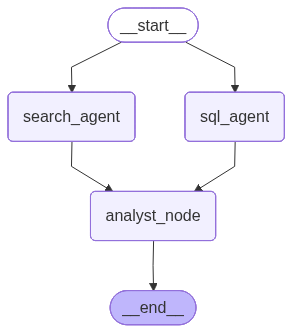

In [57]:
builder = StateGraph(SportState)
builder.add_node("sql_agent", sql_agent)
builder.add_node("search_agent", search_llm)
builder.add_node("analyst_node", analyst_node)

builder.add_edge(START, "sql_agent")
builder.add_edge(START, "search_agent")
builder.add_edge("sql_agent", "analyst_node")
builder.add_edge("search_agent", "analyst_node")


sports_analyst_agent = builder.compile(checkpointer=InMemorySaver())

from IPython.display import Image, display

display(Image(sports_analyst_agent.get_graph().draw_mermaid_png()))


In [58]:
thread_config = {"configurable": {"thread_id": "1"}}

In [59]:
sports_analyst_agent.invoke({"messages":[HumanMessage(content="Tell me about Lionel Messi’s last match and compare with his last 5 performances.")],
                             "sql_result":"", "search_result":""}, config = thread_config
                            )

---calling search agent---
write query
messages=[SystemMessage(content='\nGiven an input question, create a syntactically correct sqlite query to\nrun to help find the answer. Unless the user specifies in his question a\nspecific number of examples they wish to obtain, always limit your query to\nat most 10 results. You can order the results by a relevant column to\nreturn the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the\nfew relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema\ndescription. Be careful to not query for columns that do not exist. Also,\npay attention to which column is in which table.\n\nOnly use the following tables:\n\nCREATE TABLE "Matches" (\n\tmatch_id INTEGER, \n\tmatch_date DATE NOT NULL, \n\thome_team_id INTEGER, \n\taway_team_id INTEGER, \n\thome_score INTEGER, \n\taway_score INTEGER, \n\tvenue VARCHAR(100), \n\tPRIMARY KEY (ma

{'messages': [HumanMessage(content='Tell me about Lionel Messi’s last match and compare with his last 5 performances.', additional_kwargs={}, response_metadata={}, id='d7543fa2-65cd-448e-bfde-14623b1280b6')],
 'sql_result': 'The SQL query failed due to an "ambiguous column name" error. This means that the `match_id` column exists in both the `Matches` and `Player_Match_Stats` tables, and the query doesn\'t specify which table to take it from.\n\nTo fix this, we need to explicitly specify the table for the `match_id` column in the SELECT statement.  We also need to select more information to compare performances. Here\'s a revised SQL query that addresses the ambiguity and tries to retrieve relevant performance data:\n\nRevised SQL Query (to retrieve last match and compare with last 5, assuming relevant stats exist):\n```sql\nSELECT\n    M.match_id,\n    M.match_date,\n    PMS.goals,\n    PMS.assists,\n    PMS.minutes_played,\n    (SELECT match_date FROM Matches AS M2 JOIN Player_Match_

In [60]:
sports_analyst_agent.invoke(
    Command(resume={"feedback": "no"}),
    config=thread_config
)

---Analyst Node---
{'messages': [HumanMessage(content='Tell me about Lionel Messi’s last match and compare with his last 5 performances.', additional_kwargs={}, response_metadata={}, id='d7543fa2-65cd-448e-bfde-14623b1280b6')], 'sql_result': 'The SQL query failed due to an "ambiguous column name" error. This means that the `match_id` column exists in both the `Matches` and `Player_Match_Stats` tables, and the query doesn\'t specify which table to take it from.\n\nTo fix this, we need to explicitly specify the table for the `match_id` column in the SELECT statement.  We also need to select more information to compare performances. Here\'s a revised SQL query that addresses the ambiguity and tries to retrieve relevant performance data:\n\nRevised SQL Query (to retrieve last match and compare with last 5, assuming relevant stats exist):\n```sql\nSELECT\n    M.match_id,\n    M.match_date,\n    PMS.goals,\n    PMS.assists,\n    PMS.minutes_played,\n    (SELECT match_date FROM Matches AS M2 

{'messages': [HumanMessage(content='Tell me about Lionel Messi’s last match and compare with his last 5 performances.', additional_kwargs={}, response_metadata={}, id='d7543fa2-65cd-448e-bfde-14623b1280b6')],
 'sql_result': 'The SQL query failed due to an "ambiguous column name" error. This means that the `match_id` column exists in both the `Matches` and `Player_Match_Stats` tables, and the query doesn\'t specify which table to take it from.\n\nTo fix this, we need to explicitly specify the table for the `match_id` column in the SELECT statement.  We also need to select more information to compare performances. Here\'s a revised SQL query that addresses the ambiguity and tries to retrieve relevant performance data:\n\nRevised SQL Query (to retrieve last match and compare with last 5, assuming relevant stats exist):\n```sql\nSELECT\n    M.match_id,\n    M.match_date,\n    PMS.goals,\n    PMS.assists,\n    PMS.minutes_played,\n    (SELECT match_date FROM Matches AS M2 JOIN Player_Match_